# NuPlan

## About

NuPlan is the world's first large-scale planning benchmark for autonomous driving. The data is recorded over 4 cities - Boston, Pittsburgh, Singapore and Las Vegas. The nuPlan v1.0 dataset consists of over 15,000 logs and 1300+ hours of driving data. The nuPlan v1.1 dataset brings multiple improvements over the v1.0 dataset. Meanwhile, some log files are removed to guarantee the accuracy and reliability of the dataset.

### Structure of the Database

![](../assets/nuplan_schema.png)

### How to Obtain



### Citation



## Data Analysis

> This part is independently conducted by Tactics2D.

In [1]:
import os
import sys

sys.path.append(".")

import warnings

warnings.filterwarnings("ignore")

import logging

logging.basicConfig(level=logging.WARNING)

import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns

In [2]:
# Setting up parameters for matplotlib
mpl.rcParams.update(
    {
        "figure.dpi": 200,  # 200 for high quality
        "font.family": "DejaVu Sans Mono",
        "font.size": 6,
        "font.stretch": "semi-expanded",
        "animation.html": "jshtml",
        "animation.embed_limit": 5000,
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
        "axes.grid": False,
        "axes.facecolor": "white",
    }
)
sns.set_palette("Set2")

In [3]:
data_path = "../../data/nuplan/data/cache/"
trajectory_folders = ["train_boston", "train_pittsburgh", "train_singapore", "train_vegas_1"]
test_folder = "test"
val_folder = "val"

map_path = "../../data/nuplan/maps"
map_files = [
    "us-ma-boston/9.12.1817/map.gpkg",
    "us-pa-pittsburgh-hazelwood/9.17.1937/map.gpkg",
    "sg-one-north/9.17.1964/map.gpkg",
    "us-nv-las-vegas-strip/9.15.1915/map.gpkg",
]

In [4]:
trajectory_files = []
for folder in trajectory_folders:
    file_list = os.listdir(data_path + folder)
    trajectory_files.append(file_list)
    print(folder, len(file_list))

test_file_list = os.listdir(data_path + test_folder)
val_file_list = os.listdir(data_path + val_folder)
print(test_folder, len(test_file_list))
print(val_folder, len(val_file_list))

train_boston 1648
train_pittsburgh 1560
train_singapore 2396
train_vegas_1 1750
test 1349
val 1381


### Trajectory Types in NuPlan

The dynamic objects recorded in NuPlan include

- `vehicle`: Includes all four or more wheeled vehicles, as well as trailers.
- `bicycle`: Includes bicycles, motorcycles and tricycles.
- `pedestrian`: All types of pedestrians, incl. strollers and wheelchairs.
- `generic object`: Animals, debris, pushable/pullable objects, permanent poles.

The static objects recorded in NuPlan include

- `traffic_cone`: Cones that are temporarily placed to control the flow of traffic.
- `barrier`: Solid barriers that can be either temporary or permanent.
- `czone_sign`: Temporary signs that indicate construction zones.

In [5]:
sample_db = sqlite3.connect(data_path + trajectory_folders[0] + "/" + trajectory_files[0][0])
df_category = pd.read_sql_query("SELECT * FROM category;", sample_db)
categories = {}
for row in df_category.iterrows():
    categories[row[1]["token"]] = row[1]["name"]
    print("%s: %s" % (row[1]["name"], row[1]["description"]))

vehicle: Includes all four or more wheeled vehicles, as well as trailers.
bicycle: Includes bicycles, motorcycles and tricycles.
pedestrian: All types of pedestrians, incl. strollers and wheelchairs.
traffic_cone: Cones that are temporarily placed to control the flow of traffic.
barrier: Solid barriers that can be either temporary or permanent.
czone_sign: Temporary signs that indicate construction zones.
generic_object: Animals, debris, pushable/pullable objects, permanent poles.


### Scenario Types in NuPlan

NuPlan has its own taxonomy in scenarios. There are in total 75 types of scenarios in NuPlan dataset. The scenario types included in `train_boston`, `train_pittsburgh`, `train_singapore`, `train_vegas_1` are shown as follows.

In [6]:
scenario_types = set()
for i, trajectory_folder in enumerate(trajectory_folders):
    for trajectory_file in trajectory_files[i]:
        if trajectory_file[-3:] != ".db":
            continue
        file_path = data_path + trajectory_folder + "/" + trajectory_file
        with sqlite3.connect(data_path + trajectory_folder + "/" + trajectory_file) as db:
            df_scenario_tag = pd.read_sql_query("SELECT * FROM scenario_tag;", db)
            scenario_type_subset = set(df_scenario_tag["type"].unique())
            scenario_types = scenario_types.union(scenario_type_subset)
    db.close()

print(len(scenario_types), sorted(scenario_types))

73 ['accelerating_at_crosswalk', 'accelerating_at_stop_sign', 'accelerating_at_stop_sign_no_crosswalk', 'accelerating_at_traffic_light', 'accelerating_at_traffic_light_with_lead', 'accelerating_at_traffic_light_without_lead', 'behind_bike', 'behind_long_vehicle', 'behind_pedestrian_on_driveable', 'behind_pedestrian_on_pickup_dropoff', 'changing_lane', 'changing_lane_to_left', 'changing_lane_to_right', 'changing_lane_with_lead', 'changing_lane_with_trail', 'crossed_by_bike', 'crossed_by_vehicle', 'following_lane_with_lead', 'following_lane_with_slow_lead', 'following_lane_without_lead', 'high_lateral_acceleration', 'high_magnitude_jerk', 'high_magnitude_speed', 'low_magnitude_speed', 'medium_magnitude_speed', 'near_barrier_on_driveable', 'near_construction_zone_sign', 'near_high_speed_vehicle', 'near_long_vehicle', 'near_multiple_bikes', 'near_multiple_pedestrians', 'near_multiple_vehicles', 'near_pedestrian_at_pickup_dropoff', 'near_pedestrian_on_crosswalk', 'near_pedestrian_on_crosswa

### Map Visualization

In [7]:
def plot_map(data_path, map_file):
    map_path = data_path + "/" + map_file

    fig, ax = plt.subplots()
    fig.set_figwidth(6)
    generic_drivable_areas = gpd.read_file(map_path, layer="generic_drivable_areas")
    generic_drivable_areas.plot(ax=ax, color="lightgreen")
    lanes_polygons = gpd.read_file(map_path, layer="lanes_polygons")
    lanes_polygons.plot(ax=ax, color="gray")
    intersections = gpd.read_file(map_path, layer="intersections")
    intersections.plot(ax=ax, color="gray")
    walkways = gpd.read_file(map_path, layer="walkways")
    walkways.plot(ax=ax, color="lightgray")
    carpark_areas = gpd.read_file(map_path, layer="carpark_areas")
    carpark_areas.plot(ax=ax, color="lightgray")
    stop_polygons = gpd.read_file(map_path, layer="stop_polygons")
    stop_polygons.plot(ax=ax, color="red")
    crosswalks = gpd.read_file(map_path, layer="crosswalks")
    crosswalks.plot(ax=ax, color="lightgray")
    traffic_lights = gpd.read_file(map_path, layer="traffic_lights")
    traffic_lights.plot(ax=ax, marker="*", color="orange", markersize=0.01)

    plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.set_title(map_file.split("/")[0])
    plt.show()


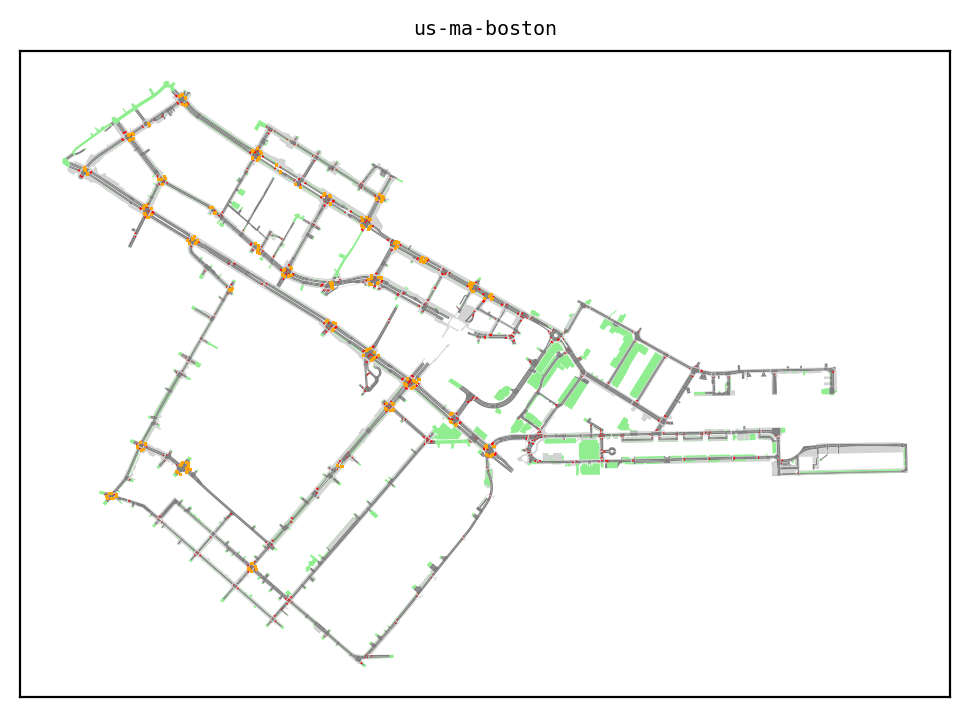

In [8]:
plot_map(map_path, map_files[0])

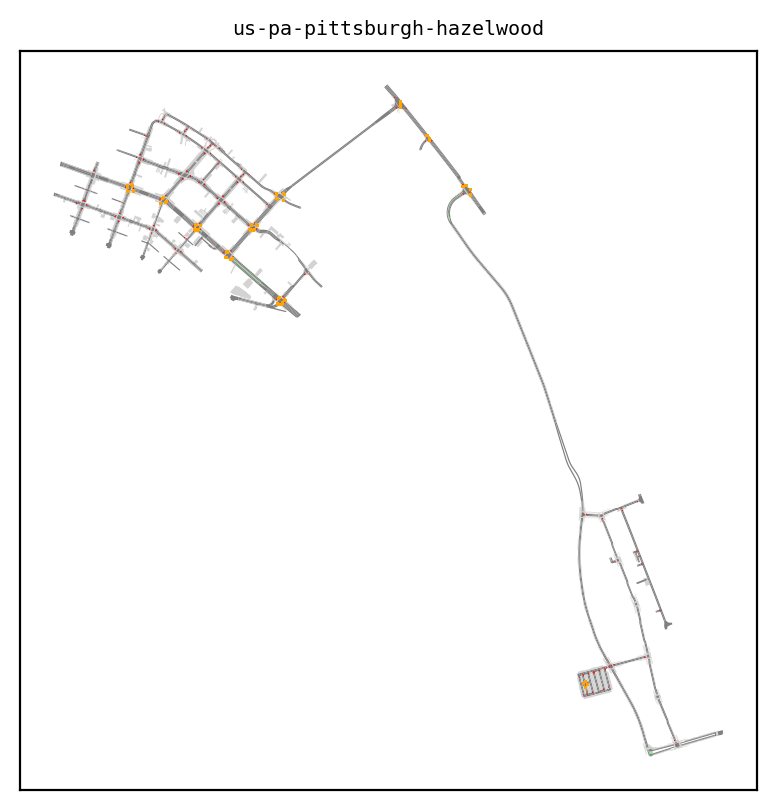

In [9]:
plot_map(map_path, map_files[1])

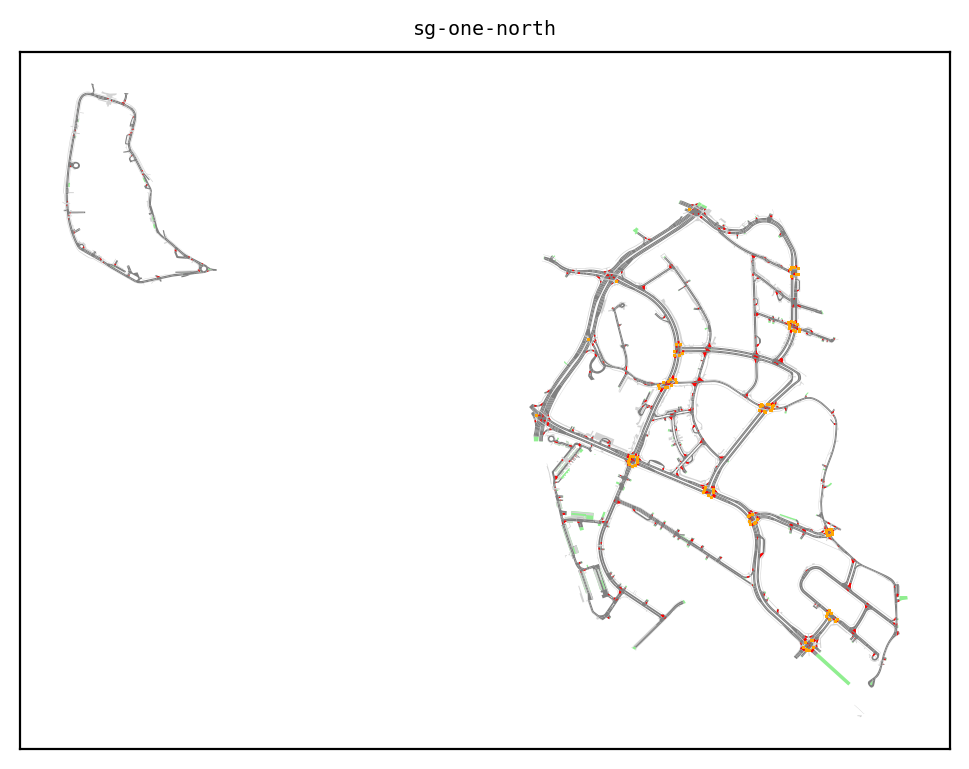

In [10]:
plot_map(map_path, map_files[2])

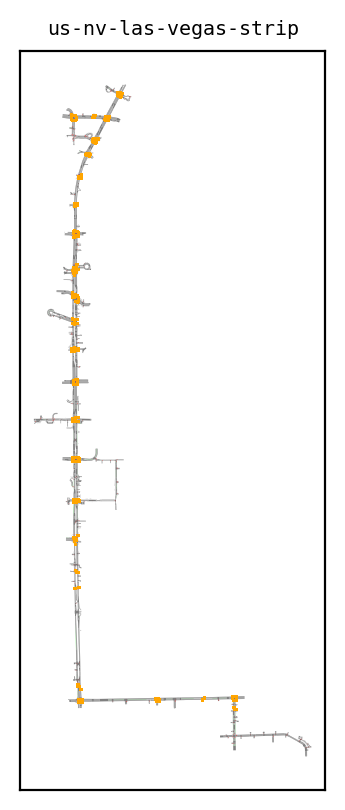

In [11]:
plot_map(map_path, map_files[3])

### Proportion of Trajectory Categories

In this analysis, our primary emphasis is on scrutinizing the distribution of dynamic objects, specifically focusing on `vehicle`, `bicycle`, `pedestrian`, and `generic_object`. Given the vast volume of trajectory databases at our disposal, we calculate proportions based on the location-level rather than the file-level. It's noteworthy that the distribution of dynamic objects exhibits significant variability across different locations.

Within the NuPlan dataset, the track data has a especially high proportion of pedestrians. This influx of pedestrian data has the potential to increase complexity to the traffic scenarios, thereby presenting more challenging dynamics for analysis and understanding.

In [12]:
dynamic_category = ["vehicle", "bicycle", "pedestrian", "generic_object"]

all_trajectory_folders = trajectory_folders + [val_folder] + [test_folder]
all_trajectory_files = trajectory_files + [val_file_list] + [test_file_list]

In [13]:
def plot_class_proportion(data_path, trajectory_folders, trajectory_files, proportion=None):
    df_proportion = pd.DataFrame(columns=dynamic_category, index=trajectory_folders)

    for i, trajectory_folder in enumerate(trajectory_folders):
        if proportion is not None:
            np.random.shuffle(trajectory_files[i])
            trajectory_files_subset = trajectory_files[i][
                : int(len(trajectory_files[i]) * proportion)
            ]
        else:
            trajectory_files_subset = trajectory_files[i]
        for trajectory_file in trajectory_files_subset:
            if trajectory_file[-3:] != ".db":
                continue
            file_path = data_path + trajectory_folder + "/" + trajectory_file
            with sqlite3.connect(file_path) as motion_db:
                df_category = pd.read_sql_query(
                    "SELECT * FROM category;", motion_db, index_col="token"
                )
                df_track = pd.read_sql_query("SELECT * FROM track;", motion_db, index_col="token")

                dict_category = dict(zip(df_category["name"], df_category.index))

                for category in dynamic_category:
                    df_proportion.loc[trajectory_folder][category] = len(
                        df_track[df_track["category_token"] == dict_category[category]]
                    )

            motion_db.close()

    if proportion is None:
        print(df_proportion)

    df_proportion = df_proportion.div(df_proportion.sum(axis=1), axis=0)
    df_proportion.plot.barh(stacked=True, colormap="Set2", rot=1)
    plt.gcf().set_figwidth(6)
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc="upper left")

                 vehicle bicycle pedestrian generic_object
train_boston         780      28        645            278
train_pittsburgh     652      25        181            261
train_singapore       23       2         52             41
train_vegas_1       1298      63       2001           2016
val                  149       8        153             25
test                 444       7        129            556


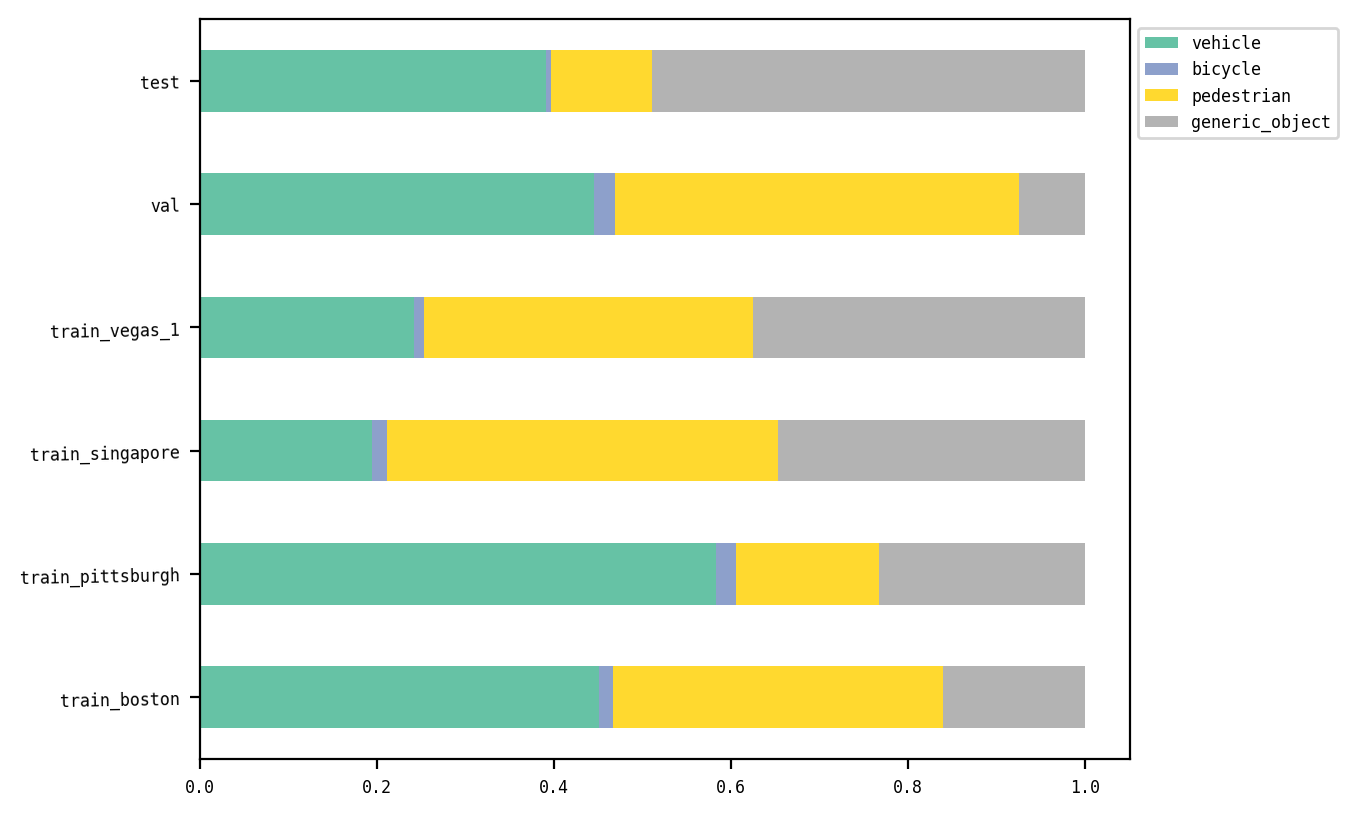

In [14]:
plot_class_proportion(data_path, all_trajectory_folders, all_trajectory_files)

### Distribution of Average Speed on Map

In [15]:
def plot_speed_distribution(
    map_boundary, data_path, trajectory_folder, trajectory_files, proportion=None
):
    x_min, x_max, y_min, y_max = map_boundary
    matrix_x = int((x_max - x_min))
    matrix_y = int((y_max - y_min))
    speed_map = np.zeros((matrix_y, matrix_x, 2))

    np.random.shuffle(trajectory_files)
    cnt = 0
    if proportion is not None:
        max_iter = int(len(trajectory_files) * proportion)

    for trajectory_file in trajectory_files:
        if not trajectory_file.endswith(".db"):
            continue
        file_path = os.path.join(data_path, trajectory_folder, trajectory_file)
        with sqlite3.connect(file_path) as motion_db:
            df_category = pd.read_sql_query("SELECT * FROM category;", motion_db, index_col="token")
            df_track = pd.read_sql_query("SELECT * FROM track;", motion_db, index_col="token")
            df_lidar_box = pd.read_sql_query("SELECT * FROM lidar_box;", motion_db)

            # 1. track_token -> category_token
            df_lidar_box["category_token"] = df_lidar_box["track_token"].map(df_track["category_token"])
            # 2. category_token -> category_name
            df_lidar_box["category"] = df_lidar_box["category_token"].map(df_category["name"])
            df_vehicle = df_lidar_box[df_lidar_box["category"] == "vehicle"]

            df_vehicle["speed"] = np.sqrt(
                df_vehicle["vx"] ** 2 + df_vehicle["vy"] ** 2 + df_vehicle["vz"] ** 2
            )

            df_vehicle["x_idx"] = (df_vehicle["x"] - x_min).astype(int)
            df_vehicle["y_idx"] = (df_vehicle["y"] - y_min).astype(int)

            valid = (
                (df_vehicle["x_idx"] >= 0) & (df_vehicle["x_idx"] < matrix_x) &
                (df_vehicle["y_idx"] >= 0) & (df_vehicle["y_idx"] < matrix_y)
            )
            df_vehicle = df_vehicle[valid]

            for (y, x), group in df_vehicle.groupby(["y_idx", "x_idx"]):
                speed_map[y, x, 0] += group["speed"].sum()
                speed_map[y, x, 1] += len(group)

        if proportion is not None:
            cnt += 1
            if cnt >= max_iter:
                break

    with np.errstate(divide='ignore', invalid='ignore'):
        speed_map[:, :, 0] = np.divide(
            speed_map[:, :, 0], speed_map[:, :, 1], out=np.zeros_like(speed_map[:, :, 0]),
            where=speed_map[:, :, 1] > 0
        )
        speed_map[:, :, 0][speed_map[:, :, 1] == 0] = np.nan
    speed_map = np.flip(speed_map, axis=0)

    im = plt.imshow(speed_map[:, :, 0], cmap="cool", vmin=0)
    plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.gcf().set_figwidth(6)
    cax = plt.gcf().add_axes(
        [
            plt.gca().get_position().x1 + 0.01,
            plt.gca().get_position().y0,
            0.02,
            plt.gca().get_position().height,
        ]
    )
    plt.gca().set_title(trajectory_folder)
    plt.colorbar(im, cax=cax)
    plt.show()

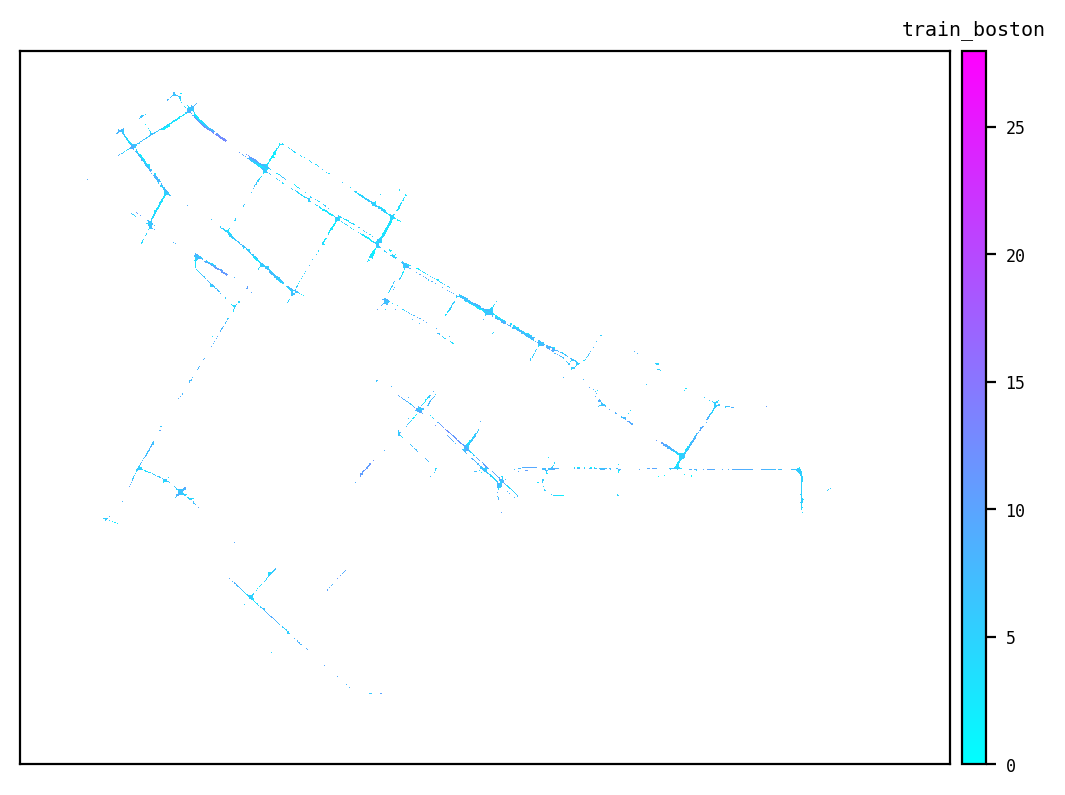

In [16]:
map_boundary_boston = [330500, 333500, 4689100, 4691400]
plot_speed_distribution(
    map_boundary_boston, data_path, trajectory_folders[0], trajectory_files[0]
)

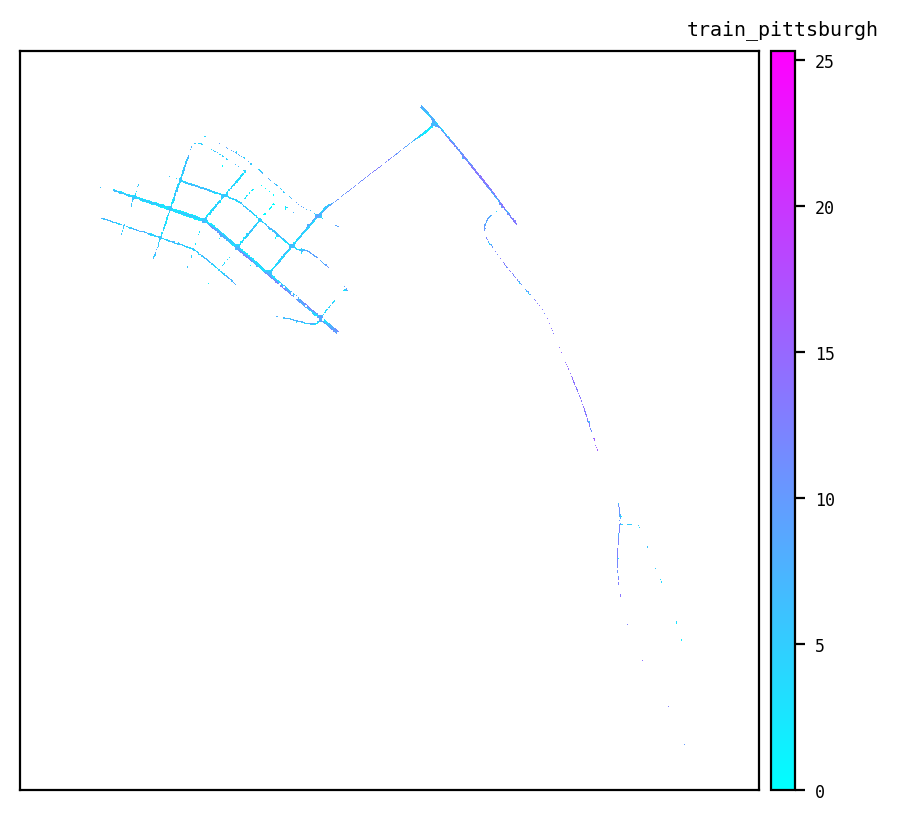

In [17]:
map_boundary_pittsburgh = [587000, 589500, 4473750, 4476250]
plot_speed_distribution(
    map_boundary_pittsburgh, data_path, trajectory_folders[1], trajectory_files[1]
)

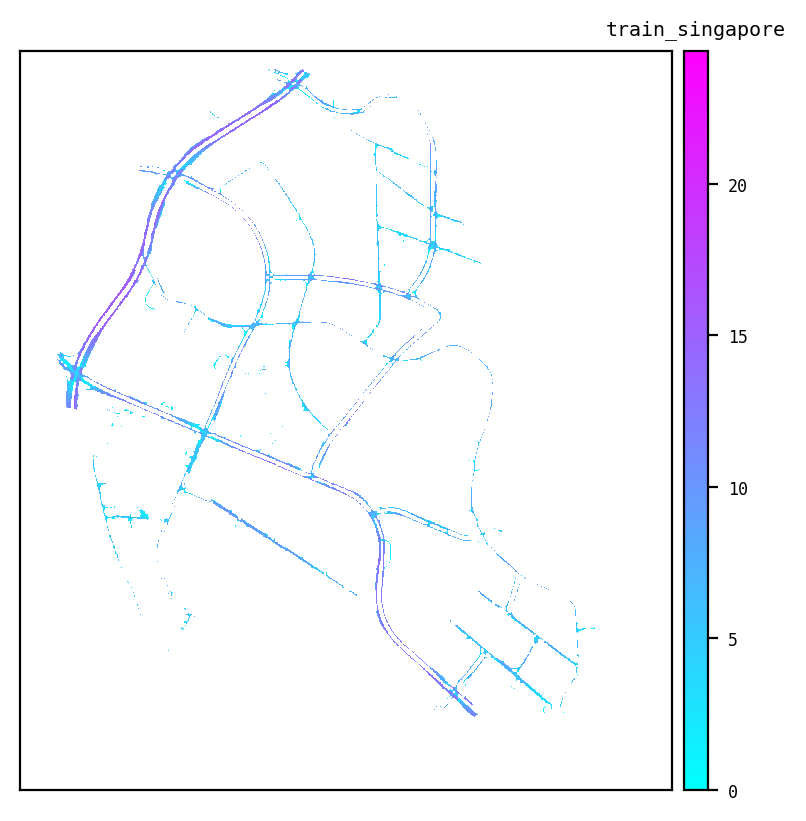

In [18]:
map_boundary_pittsburgh = [364750, 366250, 142700, 144400]
plot_speed_distribution(
    map_boundary_pittsburgh, data_path, trajectory_folders[2], trajectory_files[2]
)

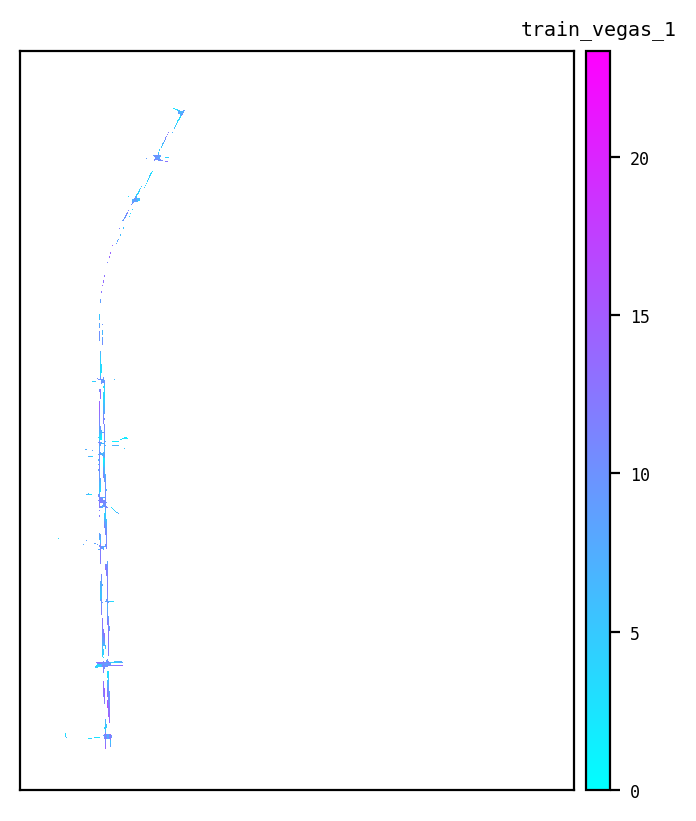

In [19]:
map_boundary_pittsburgh = [664000, 667000, 3996000, 4000000]
plot_speed_distribution(
    map_boundary_pittsburgh, data_path, trajectory_folders[3], trajectory_files[3], proportion=0.6
)

### Distribution of Speed by Trajectory Type

The speed distribution indicates that vehicles in the NuPlan dataset are frequently stationary, largely due to the dataset’s focus on urban scenarios with numerous traffic lights. The speeds of vehicles and bicycles exhibit greater variation depending on the location. In contrast, the average walking speed of pedestrians remains relatively consistent across locations, as human walking speed tends not to vary significantly.

In [22]:
def plot_speed_by_type(data_path, trajectory_folders, trajectory_files, max_files_per_folder=100):
    speeds = []

    for i, trajectory_folder in enumerate(trajectory_folders):
        files = trajectory_files[i]
        if max_files_per_folder is not None:
            np.random.shuffle(files)
            files = files[:max_files_per_folder]
        for trajectory_file in files:
            if not trajectory_file.endswith(".db"):
                continue
            file_path = os.path.join(data_path, trajectory_folder, trajectory_file)
            with sqlite3.connect(file_path) as motion_db:
                df_category = pd.read_sql_query("SELECT * FROM category;", motion_db, index_col="token")
                df_track = pd.read_sql_query("SELECT * FROM track;", motion_db, index_col="token")
                df_lidar_box = pd.read_sql_query("SELECT * FROM lidar_box;", motion_db)

                df_lidar_box["category_token"] = df_lidar_box["track_token"].map(df_track["category_token"])
                df_lidar_box["class"] = df_lidar_box["category_token"].map(df_category["name"])
                df_lidar_box["speed"] = np.sqrt(
                    df_lidar_box["vx"] ** 2 + df_lidar_box["vy"] ** 2 + df_lidar_box["vz"] ** 2
                )
                df_lidar_box["location"] = trajectory_folder
                speeds.append(df_lidar_box[["location", "class", "speed"]])

    df = pd.concat(speeds, ignore_index=True)
    plot = sns.FacetGrid(
        df,
        col="location",
        col_wrap=2,
        sharex=True,
        sharey=False,
        hue="class",
        palette="Set2",
        hue_order=dynamic_category,
    )

    plot.map(sns.histplot, "speed", stat="percent", element="step", kde=False, bins=50)
    plot.set(xlim=(0, 25))
    legend_ax = plot.axes.flat[1]
    handles, labels = legend_ax.get_legend_handles_labels()
    legend_ax.legend(handles, labels, loc="upper right", title="class")
    plt.show()

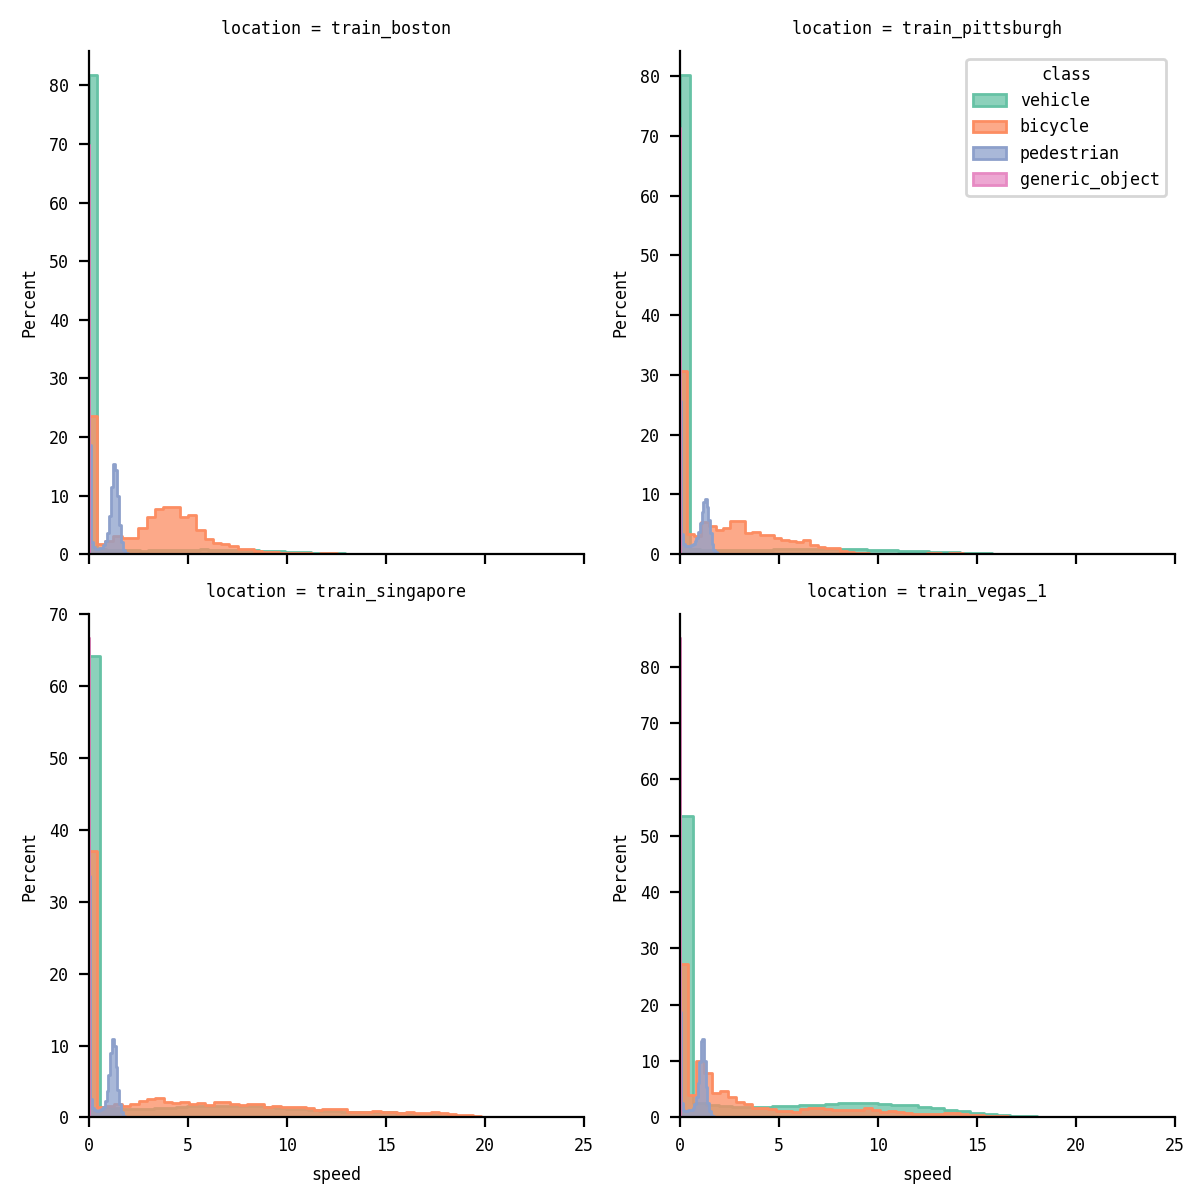

In [23]:
plot_speed_by_type(data_path, trajectory_folders, trajectory_files)

## Tactics2D Integration

### Dataset Preparation

You can place the NuPlan dataset in any directory of your choice. However, it is suggested to maintain the original folder structure for compatibility.

```shell
nuplan
├── data/cache
│   ├── train_boston
│   │        ├── 2021.08.18.18.32.06_veh-28_00049_00111.db
│   │        ├── ...
│   ├── train_pittsburgh
│   ├── train_singapore
│   ├── train_vegas_1
│   ├── val
│   ├── test
├── maps
│   ├── sg-one-north/9.17.1964
│   │        ├── map.gpkg
│   ├── us-ma-boston/9.12.1817
│   │        ├── map.gpkg
│   ├── us-nv-las-vegas-strip/9.15.1915
│   │        ├── drivable_area.npy.npz
│   │        ├── intensity.npy.npz
│   │        ├── map.gpkg
│   ├── us-pa-pittsburgh-hazelwood/9.17.1937
│   │        ├── map.gpkg
│   ├── nuplan-maps-v1.0.json
```

### Class Mapping

The table below illustrates how classes from the highD dataset are mapped to corresponding traffic participants in NuPlan.

| NuPlan Class | Tactics2D Class |
| --- | --- |
| vehicle | `tactics2d.participant.element.Vehicle` |
| bicycle | `tactics2d.participant.element.Cyclist` |
| pedestrian | `tactics2d.participant.element.Pedestrian` |
| traffic_cone | `tactics2d.participant.element.Other` |
| barrier | `tactics2d.participant.element.Other` |
| czone | `tactics2d.participant.element.Other` |
| generic_object | `tactics2d.participant.element.Other` |

### Map Parsing

NuPlan records four locations for its dataset in the form of geopackage file (`.gkpg`). The map file includes the following layers:

- baseline_paths*
- boundaries
- carpark_areas
- crosswalks
- dubins_nodes*
- generic_drivable_areas
- gen_lane_connectors_scaled_width_polygons*
- intersections*
- lane_connectors
- lane_group_connectors*
- lane_groups_polygons*
- lanes_polygons
- meta
- road_segments
- stop_polygons*
- traffic_lights
- walkways

To align with Tactics2D's data structure, we use those layers without * for data parsing.

### Parse and Replay Logs

To parse, replay, and visualize the NuPlan dataset using Tactics2D, you can use the following code snippet.

In [8]:
%matplotlib notebook

import os
import numpy as np
from matplotlib.animation import FuncAnimation
from shapely.geometry import Point
from IPython.display import HTML

from tactics2d.dataset_parser import NuPlanParser
from tactics2d.map.parser import GPKGParser
from tactics2d.sensor import BEVCamera
from tactics2d.renderer import MatplotlibRenderer
from tactics2d.map.map_config import NUPLAN_MAP_CONFIG

In [9]:
dataset_path = "../../data/nuplan/data/cache"  # Replace with your dataset path
map_path = "../../data/nuplan/maps"
dataset_parser = NuPlanParser()
map_parser = GPKGParser("nuplan")

In [10]:
def render_nuplan(map_, participants, stamp_range):
    x_min = np.inf
    x_max = -np.inf
    y_min = np.inf
    y_max = - np.inf

    for participant in participants.values():
        trace = np.array(
            participant.trajectory.get_trace(frame_range=(stamp_range[0], stamp_range[-1]))
        )
        if len(trace) == 0:
            continue
        x_min = min(x_min, np.min(trace[:, 0]))
        x_max = max(x_max, np.max(trace[:, 0]))
        y_min = min(y_min, np.min(trace[:, 1]))
        y_max = max(y_max, np.max(trace[:, 1]))
    
    camera_position = np.array([(x_min + x_max) / 2, (y_min + y_max)/2])
    camera = BEVCamera(id_=0, map_=map_)

    x = x_max - x_min
    y = y_max - y_min

    renderer = MatplotlibRenderer(xlim=(-x/2, x/2), ylim=(-y/2, y/2), resolution=(2000, 1000))

    fig = renderer.fig  # Use the one already created
    frame_list = stamp_range
    prev_road_id_set = set()
    prev_participant_id_set = set()

    def update(frame):
        nonlocal prev_road_id_set, prev_participant_id_set

        participant_ids = [pid for pid, p in participants.items() if p.is_active(frame)]

        geometry_data, prev_road_id_set, prev_participant_id_set = camera.update(
            frame,
            participants,
            participant_ids,
            prev_road_id_set,
            prev_participant_id_set,
            Point(camera_position),
        )

        renderer.update(geometry_data, camera_position)
        renderer.ax.set_title(f"Frame: {frame}")

    ani = FuncAnimation(fig, update, frames=frame_list, interval=50, repeat=True)
    return ani

By examining extended segments of the NuPlan dataset, several key characteristics become evident:

- The dataset is centered around the data-collecting (ego) vehicle and only includes trajectories of surrounding vehicles within the ego vehicle’s perception range at each time frame.
- Caution is needed when interpreting the perception results. Object positions may fluctuate slightly around their actual locations, and vehicle headings may occasionally be misestimated in some frames.

In [1]:
data_file = "2021.08.18.18.32.06_veh-28_00049_00111.db"
data_path = os.path.join(dataset_path, "train_boston")

location = dataset_parser.get_location(data_file, data_path)
map_config = NUPLAN_MAP_CONFIG[location]
map_file = map_config["folder"] + "/" + map_config["gpkg_file"]
print(f"Displaying log replay at {location}")

participants, actual_stamp_range = dataset_parser.parse_trajectory(data_file, data_path)
map_ = map_parser.parse(os.path.join(map_path, map_file))

ani = render_nuplan(map_, participants, actual_stamp_range)
HTML(ani.to_html5_video())

NameError: name 'os' is not defined

In [ ]:
data_file = "2021.08.17.13.10.50_veh-08_00313_00564.db"
data_path = os.path.join(dataset_path, "train_pittsburgh")

location = dataset_parser.get_location(data_file, data_path)
map_config = NUPLAN_MAP_CONFIG[location]
map_file = map_config["folder"] + "/" + map_config["gpkg_file"]
print(f"Displaying log replay at {location}")

participants, actual_stamp_range = dataset_parser.parse_trajectory(data_file, data_path)
map_ = map_parser.parse(os.path.join(map_path, map_file))

ani = render_nuplan(map_, participants, actual_stamp_range[:200])
HTML(ani.to_html5_video())

<IPython.core.display.Javascript object>

In [ ]:
data_file = "2021.08.18.06.04.33_veh-51_00016_00170.db"
data_path = os.path.join(dataset_path, "train_singapore")

location = dataset_parser.get_location(data_file, data_path)
map_config = NUPLAN_MAP_CONFIG[location]
map_file = map_config["folder"] + "/" + map_config["gpkg_file"]
print(f"Displaying log replay at {location}")

participants, actual_stamp_range = dataset_parser.parse_trajectory(data_file, data_path)
map_ = map_parser.parse(os.path.join(map_path, map_file))

ani = render_nuplan(map_, participants, actual_stamp_range[200:400])
HTML(ani.to_html5_video())

<IPython.core.display.Javascript object>

In [ ]:
data_file = "2021.05.12.19.36.12_veh-35_00005_00204.db"
data_path = os.path.join(dataset_path, "train_vegas_1")

location = dataset_parser.get_location(data_file, data_path)
map_config = NUPLAN_MAP_CONFIG[location]
map_file = map_config["folder"] + "/" + map_config["gpkg_file"]
print(f"Displaying log replay at {location}")

participants, actual_stamp_range = dataset_parser.parse_trajectory(data_file, data_path)
map_ = map_parser.parse(os.path.join(map_path, map_file))

ani = render_nuplan(map_, participants, actual_stamp_range[400:600])
HTML(ani.to_html5_video())

Displaying log replay at las_vegas


<IPython.core.display.Javascript object>